# Obtenção dos arquivos necessários para a prática
Os arquivos a serem utilizados estão disponibilizados [aqui](https://github.com/grsart/BiomolComp/tree/main/Pratica1). Faça o download antes de começar a prática.



# Inspeção visual do cromatograma #

1. Baixe os cromatogramas utilizando os links acima:

2.  Abra o primeiro cromatograma com o programa [SnapGene Viewer](https://www.snapgene.com/snapgene-viewer);

3. Inspecione o cromatograma em toda sua extensão. Tente definir uma base a partir da qual você não considere a atribuição de bases totalmente confiável. O que pode ser dito, por exemplo, sobre a base de número 411 no sequenciamento *forward* ?

4. Repita o mesmo procedimento para o cromatograma da mesma molécula sequenciado com o outro primer (ex: 121107H07R);

5. No botão **Chromatogram Data**, selecione a sequência obtida com o primer *forward*.

# Análise de sequência e de qualidade em um arquivo FASTQ

Este notebook faz análises de um único arquivo FASTQ. Isso inclui composição de sequência e análise de qualidade de pontuação de um sequenciamento.




## 📦 Preparação e instalação

In [2]:
# Install required packages
!pip install biopython matplotlib seaborn pandas numpy plotly

# Import libraries
from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter, defaultdict
import gzip
import io
from google.colab import files
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ All packages installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 36.7 MB/s eta 0:00:00
✅ All packages installed successfully!


## 📁 Carregue o seu arquivo FASTAQ
Nesta etapa, o arquivo FASTQ obtido por meio de Download deve ser carregado.  
Antes disso, inspecione o arquivo em um visualizador. Verifique as informações constantes. Utilize a tabela abaixo para converter as primeiras pontuações do arquivo.  
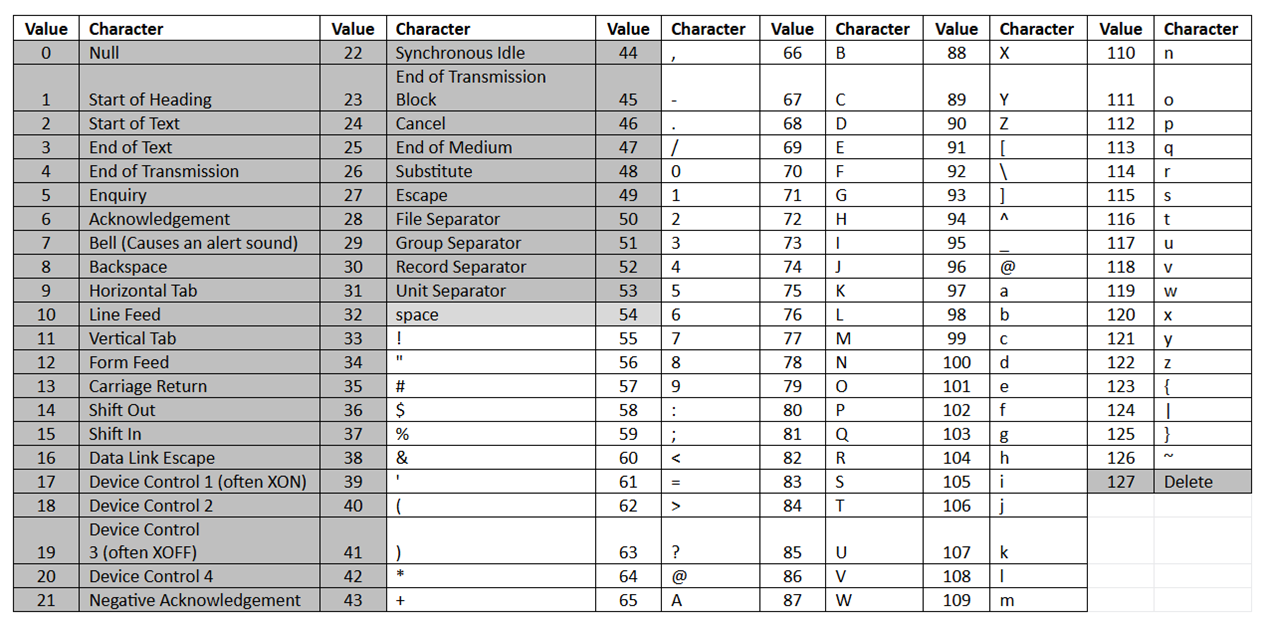


Primeiramente, carregaremos o arquivo de leitura Foward (121107G02F.fastq)




In [5]:
print("📁 Upload your FASTQ file")
print("Supported formats: .fastq, .fq, .fastq.gz, .fq.gz")

# Upload file
uploaded = files.upload()

# Get the uploaded filename
fastq_filename = list(uploaded.keys())[0]
print(f"\n✅ File uploaded: {fastq_filename}")
print(f"File size: {len(uploaded[fastq_filename]) / 1024:.1f} KB")


📁 Upload your FASTQ file
Supported formats: .fastq, .fq, .fastq.gz, .fq.gz


Saving 121107G02F.fastq to 121107G02F.fastq

✅ File uploaded: 121107G02F.fastq
File size: 1.9 KB


## 🔍 Bloco de inicialização das funções de inspeção e análise de arquivos FASTQ

In [6]:
class FastqAnalyzer:
    def __init__(self, filename):
        self.filename = filename
        self.sequences = []
        self.qualities = []
        self.quality_arrays = []
        self.base_counts = Counter()
        self.quality_by_position = defaultdict(list)
        self.gc_contents = []
        self.read_lengths = []
        self.total_reads = 0
        self.total_bases = 0

    def load_and_analyze(self, max_reads=None):
        """Load FASTQ file and perform initial analysis"""
        print(f"🔬 Analyzing FASTQ file: {self.filename}")

        # Handle compressed files
        if self.filename.endswith('.gz'):
            handle = gzip.open(self.filename, "rt")
        else:
            handle = open(self.filename, "r")

        try:
            for i, record in enumerate(SeqIO.parse(handle, "fastq")):
                if max_reads and i >= max_reads:
                    break

                sequence = str(record.seq).upper()
                qualities = record.letter_annotations["phred_quality"]

                # Store data
                self.sequences.append(sequence)
                self.qualities.append(qualities)
                self.quality_arrays.append(np.array(qualities))

                # Calculate statistics
                self.base_counts.update(sequence)
                self.read_lengths.append(len(sequence))

                # GC content for this read
                gc_count = sequence.count('G') + sequence.count('C')
                at_count = sequence.count('A') + sequence.count('T')
                total_valid = gc_count + at_count
                if total_valid > 0:
                    gc_content = (gc_count / total_valid) * 100
                    self.gc_contents.append(gc_content)

                # Quality by position
                for pos, qual in enumerate(qualities):
                    self.quality_by_position[pos].append(qual)

                self.total_reads += 1

                if (i + 1) % 10000 == 0:
                    print(f"  Processed {i + 1:,} reads...")

        finally:
            handle.close()

        self.total_bases = sum(self.read_lengths)
        print(f"✅ Analysis complete: {self.total_reads:,} reads, {self.total_bases:,} bases")

        return self.total_reads

    def get_basic_statistics(self):
        """Calculate comprehensive statistics"""
        if not self.sequences:
            return None

        # Base composition statistics
        stats = {
            'total_reads': self.total_reads,
            'total_bases': self.total_bases,
            'base_counts': dict(self.base_counts),
            'base_percentages': {
                base: (count / self.total_bases) * 100
                for base, count in self.base_counts.items()
            }
        }

        # Calculate composition ratios
        a_count = self.base_counts.get('A', 0)
        t_count = self.base_counts.get('T', 0)
        g_count = self.base_counts.get('G', 0)
        c_count = self.base_counts.get('C', 0)
        n_count = self.base_counts.get('N', 0)

        valid_bases = a_count + t_count + g_count + c_count

        if valid_bases > 0:
            stats['gc_content'] = ((g_count + c_count) / valid_bases) * 100
            stats['at_content'] = ((a_count + t_count) / valid_bases) * 100

        # Read length statistics
        stats['length_stats'] = {
            'mean': np.mean(self.read_lengths),
            'median': np.median(self.read_lengths),
            'min': min(self.read_lengths),
            'max': max(self.read_lengths),
            'std': np.std(self.read_lengths)
        }

        # Quality statistics
        all_qualities = []
        for qual_array in self.quality_arrays:
            all_qualities.extend(qual_array)

        stats['quality_stats'] = {
            'mean': np.mean(all_qualities),
            'median': np.median(all_qualities),
            'min': min(all_qualities),
            'max': max(all_qualities),
            'std': np.std(all_qualities)
        }

        # Quality thresholds
        q20_bases = sum(1 for q in all_qualities if q >= 20)
        q30_bases = sum(1 for q in all_qualities if q >= 30)

        stats['quality_thresholds'] = {
            'q20_count': q20_bases,
            'q30_count': q30_bases,
            'q20_percentage': (q20_bases / len(all_qualities)) * 100,
            'q30_percentage': (q30_bases / len(all_qualities)) * 100
        }

        # GC content distribution
        if self.gc_contents:
            stats['gc_distribution'] = {
                'mean': np.mean(self.gc_contents),
                'median': np.median(self.gc_contents),
                'std': np.std(self.gc_contents),
                'min': min(self.gc_contents),
                'max': max(self.gc_contents)
            }

        return stats

    def print_summary(self):
        """Print comprehensive summary statistics"""
        stats = self.get_basic_statistics()
        if not stats:
            print("No data to analyze")
            return

        print("\n" + "="*70)
        print("📊 FASTQ FILE ANALYSIS SUMMARY")
        print("="*70)

        # Basic info
        print(f"📁 File: {self.filename}")
        print(f"🧬 Total reads: {stats['total_reads']:,}")
        print(f"🧬 Total bases: {stats['total_bases']:,}")

        # Read length statistics
        length_stats = stats['length_stats']
        print(f"\n📏 Read Length Statistics:")
        print(f"   Mean length: {length_stats['mean']:.1f} bp")
        print(f"   Median length: {length_stats['median']:.1f} bp")
        print(f"   Length range: {length_stats['min']:.0f} - {length_stats['max']:.0f} bp")
        print(f"   Standard deviation: {length_stats['std']:.1f} bp")

        # Base composition
        print(f"\n🧬 Base Composition:")
        for base in ['A', 'T', 'G', 'C', 'N']:
            count = stats['base_counts'].get(base, 0)
            percentage = stats['base_percentages'].get(base, 0)
            print(f"   {base}: {count:>12,} ({percentage:>5.2f}%)")

        # Composition ratios
        print(f"\n📈 Composition Ratios:")
        print(f"   GC content: {stats.get('gc_content', 0):.2f}%")
        print(f"   AT content: {stats.get('at_content', 0):.2f}%")

        # Quality statistics
        qual_stats = stats['quality_stats']
        print(f"\n⭐ Quality Statistics:")
        print(f"   Mean quality: {qual_stats['mean']:.2f}")
        print(f"   Median quality: {qual_stats['median']:.2f}")
        print(f"   Quality range: {qual_stats['min']:.0f} - {qual_stats['max']:.0f}")
        print(f"   Standard deviation: {qual_stats['std']:.2f}")

        # Quality thresholds
        qual_thresh = stats['quality_thresholds']
        print(f"\n🎯 Quality Thresholds:")
        print(f"   Bases ≥ Q20: {qual_thresh['q20_count']:,} ({qual_thresh['q20_percentage']:.1f}%)")
        print(f"   Bases ≥ Q30: {qual_thresh['q30_count']:,} ({qual_thresh['q30_percentage']:.1f}%)")

        # GC distribution
        if 'gc_distribution' in stats:
            gc_dist = stats['gc_distribution']
            print(f"\n🔍 GC Content Distribution:")
            print(f"   Mean GC: {gc_dist['mean']:.2f}%")
            print(f"   GC range: {gc_dist['min']:.1f}% - {gc_dist['max']:.1f}%")
            print(f"   GC std dev: {gc_dist['std']:.2f}%")

# Initialize analyzer
analyzer = FastqAnalyzer(fastq_filename)

# Analyze the file (limit to 50,000 reads for faster processing in demo)
# Set max_reads=None to analyze all reads
read_count = analyzer.load_and_analyze(max_reads=50000)

# Print summary
analyzer.print_summary()

🔬 Analyzing FASTQ file: 121107G02F.fastq
✅ Analysis complete: 1 reads, 942 bases

📊 FASTQ FILE ANALYSIS SUMMARY
📁 File: 121107G02F.fastq
🧬 Total reads: 1
🧬 Total bases: 942

📏 Read Length Statistics:
   Mean length: 942.0 bp
   Median length: 942.0 bp
   Length range: 942 - 942 bp
   Standard deviation: 0.0 bp

🧬 Base Composition:
   A:          305 (32.38%)
   T:          227 (24.10%)
   G:          148 (15.71%)
   C:          243 (25.80%)
   N:           19 ( 2.02%)

📈 Composition Ratios:
   GC content: 42.36%
   AT content: 57.64%

⭐ Quality Statistics:
   Mean quality: 16.94
   Median quality: 14.00
   Quality range: 0 - 55
   Standard deviation: 12.82

🎯 Quality Thresholds:
   Bases ≥ Q20: 341 (36.2%)
   Bases ≥ Q30: 178 (18.9%)

🔍 GC Content Distribution:
   Mean GC: 42.36%
   GC range: 42.4% - 42.4%
   GC std dev: 0.00%


## 📊 Gráficos de análise de qualidade.
Nesta etapa, serão gerados seis gráficos

- Pontuação de qualidade por base
- Distribuição de pontuação de qualidade
- Distribuição de tamanhos de leitura
- Grafico em pizza de composição de bases na sequência
- Distribuição de conteúdo GC
- Cobertura por base


📊 Creating Quality Analysis Plots...


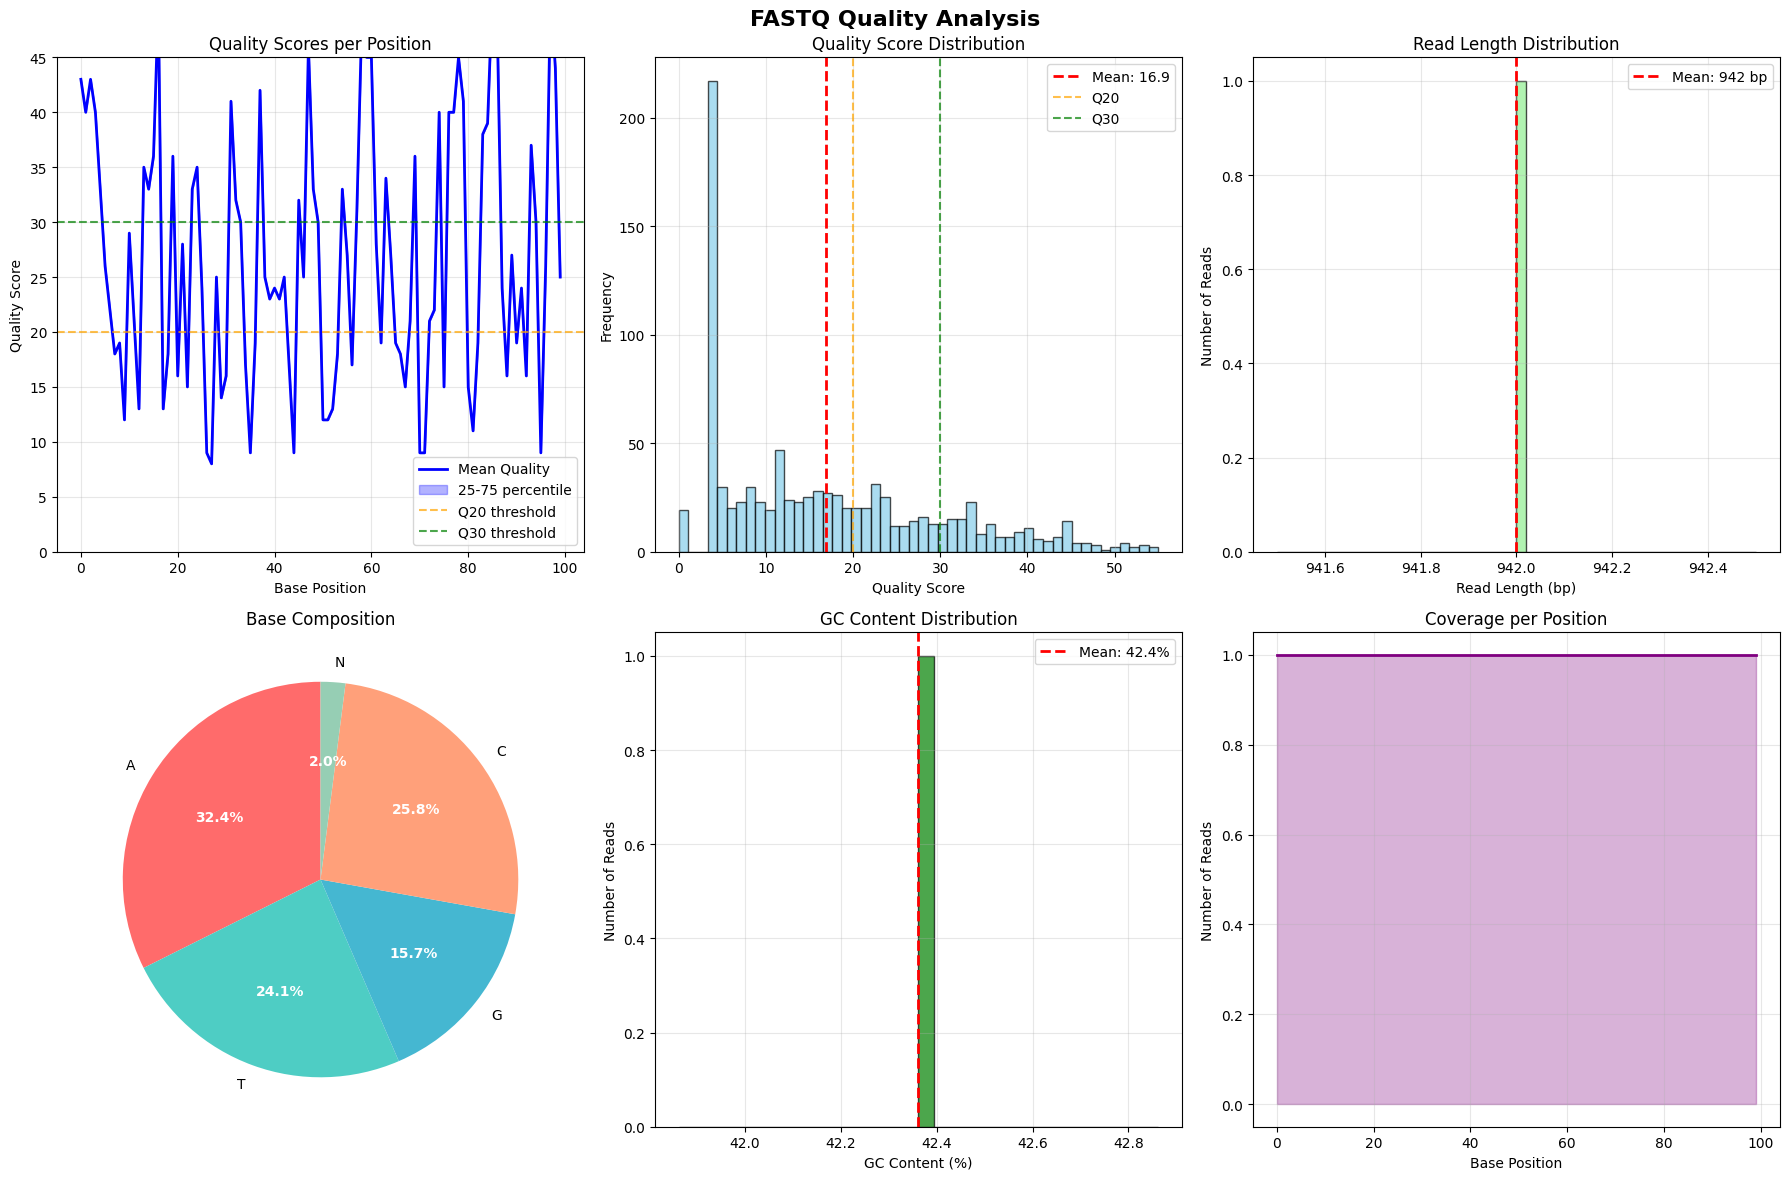

In [7]:
def plot_quality_analysis(analyzer):
    """Create comprehensive quality analysis plots"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('FASTQ Quality Analysis', fontsize=16, fontweight='bold')

    # Plot 1: Quality scores per base position
    ax1 = axes[0, 0]
    max_length = max(analyzer.read_lengths) if analyzer.read_lengths else 0
    positions = list(range(min(100, max_length)))  # Limit to first 100 positions

    mean_qualities = []
    q25_qualities = []
    q75_qualities = []

    for pos in positions:
        if pos in analyzer.quality_by_position:
            quals = analyzer.quality_by_position[pos]
            mean_qualities.append(np.mean(quals))
            q25_qualities.append(np.percentile(quals, 25))
            q75_qualities.append(np.percentile(quals, 75))
        else:
            mean_qualities.append(np.nan)
            q25_qualities.append(np.nan)
            q75_qualities.append(np.nan)

    ax1.plot(positions, mean_qualities, 'b-', linewidth=2, label='Mean Quality')
    ax1.fill_between(positions, q25_qualities, q75_qualities,
                     alpha=0.3, color='blue', label='25-75 percentile')
    ax1.axhline(y=20, color='orange', linestyle='--', alpha=0.7, label='Q20 threshold')
    ax1.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Q30 threshold')
    ax1.set_xlabel('Base Position')
    ax1.set_ylabel('Quality Score')
    ax1.set_title('Quality Scores per Position')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 45)

    # Plot 2: Quality score distribution
    ax2 = axes[0, 1]
    all_qualities = []
    for qual_array in analyzer.quality_arrays:
        all_qualities.extend(qual_array)

    ax2.hist(all_qualities, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(np.mean(all_qualities), color='red', linestyle='--',
               linewidth=2, label=f'Mean: {np.mean(all_qualities):.1f}')
    ax2.axvline(20, color='orange', linestyle='--', alpha=0.7, label='Q20')
    ax2.axvline(30, color='green', linestyle='--', alpha=0.7, label='Q30')
    ax2.set_xlabel('Quality Score')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Quality Score Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Read length distribution
    ax3 = axes[0, 2]
    ax3.hist(analyzer.read_lengths, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    ax3.axvline(np.mean(analyzer.read_lengths), color='red', linestyle='--',
               linewidth=2, label=f'Mean: {np.mean(analyzer.read_lengths):.0f} bp')
    ax3.set_xlabel('Read Length (bp)')
    ax3.set_ylabel('Number of Reads')
    ax3.set_title('Read Length Distribution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Base composition pie chart
    ax4 = axes[1, 0]
    bases = ['A', 'T', 'G', 'C', 'N']
    counts = [analyzer.base_counts.get(base, 0) for base in bases]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#96CEB4']

    # Only plot bases that exist
    existing_data = [(base, count, color) for base, count, color in zip(bases, counts, colors) if count > 0]
    if existing_data:
        bases, counts, colors = zip(*existing_data)
        wedges, texts, autotexts = ax4.pie(counts, labels=bases, colors=colors,
                                          autopct='%1.1f%%', startangle=90)
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
    ax4.set_title('Base Composition')

    # Plot 5: GC content distribution
    ax5 = axes[1, 1]
    if analyzer.gc_contents:
        ax5.hist(analyzer.gc_contents, bins=30, alpha=0.7, color='green', edgecolor='black')
        ax5.axvline(np.mean(analyzer.gc_contents), color='red', linestyle='--',
                   linewidth=2, label=f'Mean: {np.mean(analyzer.gc_contents):.1f}%')
        ax5.set_xlabel('GC Content (%)')
        ax5.set_ylabel('Number of Reads')
        ax5.set_title('GC Content Distribution')
        ax5.legend()
        ax5.grid(True, alpha=0.3)

    # Plot 6: Coverage per position
    ax6 = axes[1, 2]
    coverage = [len(analyzer.quality_by_position[pos]) for pos in positions]
    ax6.plot(positions, coverage, 'purple', linewidth=2)
    ax6.fill_between(positions, coverage, alpha=0.3, color='purple')
    ax6.set_xlabel('Base Position')
    ax6.set_ylabel('Number of Reads')
    ax6.set_title('Coverage per Position')
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Create quality analysis plots
print("\n📊 Creating Quality Analysis Plots...")
plot_quality_analysis(analyzer)

## 🎨 Interactive Quality Plots (Plotly)

In [9]:
def create_interactive_plots(analyzer):
    """Create interactive plots using Plotly"""

    # Prepare data for plotting
    max_pos = min(100, max(analyzer.read_lengths)) if analyzer.read_lengths else 0
    positions = list(range(max_pos))

    mean_qualities = []
    median_qualities = []
    q25_qualities = []
    q75_qualities = []
    coverage = []

    for pos in positions:
        if pos in analyzer.quality_by_position:
            quals = analyzer.quality_by_position[pos]
            mean_qualities.append(np.mean(quals))
            median_qualities.append(np.median(quals))
            q25_qualities.append(np.percentile(quals, 25))
            q75_qualities.append(np.percentile(quals, 75))
            coverage.append(len(quals))
        else:
            mean_qualities.append(None)
            median_qualities.append(None)
            q25_qualities.append(None)
            q75_qualities.append(None)
            coverage.append(0)

    # Create subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Quality Scores per Position', 'Quality Distribution',
                       'GC Content Distribution', 'Read Length vs Quality'),
        specs=[[{"secondary_y": True}, {"type": "histogram"}],
               [{"type": "histogram"}, {"type": "scatter"}]]
    )

    # Plot 1: Quality scores per position
    fig.add_trace(
        go.Scatter(x=positions, y=mean_qualities, mode='lines', name='Mean Quality',
                  line=dict(color='blue', width=2)),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(x=positions, y=q75_qualities, mode='lines', name='Q75',
                  line=dict(color='blue', width=0), showlegend=False),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(x=positions, y=q25_qualities, mode='lines', name='Q25-Q75',
                  fill='tonexty', fillcolor='rgba(0,0,255,0.2)',
                  line=dict(color='blue', width=0)),
        row=1, col=1
    )

    # Add Q20 and Q30 lines
    fig.add_hline(y=20, line_dash="dash", line_color="orange",
                  annotation_text="Q20", row=1, col=1)
    fig.add_hline(y=30, line_dash="dash", line_color="green",
                  annotation_text="Q30", row=1, col=1)

    # Coverage on secondary y-axis
    fig.add_trace(
        go.Scatter(x=positions, y=coverage, mode='lines', name='Coverage',
                  line=dict(color='purple', width=1), yaxis='y2'),
        row=1, col=1, secondary_y=True
    )

    # Plot 2: Quality distribution
    all_qualities = []
    for qual_array in analyzer.quality_arrays:
        all_qualities.extend(qual_array)

    fig.add_trace(
        go.Histogram(x=all_qualities, nbinsx=50, name='Quality Distribution',
                    marker_color='skyblue'),
        row=1, col=2
    )

    # Plot 3: GC content distribution
    if analyzer.gc_contents:
        fig.add_trace(
            go.Histogram(x=analyzer.gc_contents, nbinsx=30, name='GC Content',
                        marker_color='green'),
            row=2, col=1
        )

    # Plot 4: Read length vs average quality
    read_avg_qualities = [np.mean(qual_array) for qual_array in analyzer.quality_arrays]

    fig.add_trace(
        go.Scatter(x=analyzer.read_lengths, y=read_avg_qualities,
                  mode='markers', name='Read Quality vs Length',
                  marker=dict(color='red', size=4, opacity=0.6)),
        row=2, col=2
    )

    # Update layout
    fig.update_layout(height=800, showlegend=True,
                     title_text="Interactive FASTQ Quality Analysis")

    fig.update_xaxes(title_text="Base Position", row=1, col=1)
    fig.update_yaxes(title_text="Quality Score", row=1, col=1)
    fig.update_yaxes(title_text="Coverage", secondary_y=True, row=1, col=1)

    fig.update_xaxes(title_text="Quality Score", row=1, col=2)
    fig.update_yaxes(title_text="Count", row=1, col=2)

    fig.update_xaxes(title_text="GC Content (%)", row=2, col=1)
    fig.update_yaxes(title_text="Count", row=2, col=1)

    fig.update_xaxes(title_text="Read Length (bp)", row=2, col=2)
    fig.update_yaxes(title_text="Average Quality", row=2, col=2)

    fig.show()

# Create interactive plots
print("\n🎨 Creating Interactive Quality Plots...")
create_interactive_plots(analyzer)


🎨 Creating Interactive Quality Plots...


## 🔍 Detailed Quality Assessment

A qualidade do sequenciamento de cada nucleotídeo pode ser avaliado pelo cálculo de uma pontuação de qualidade. Esta pontuação de qualidade é relacionado à probabilidade de erro de leitura da base seguindo a seguinte formula:

\begin{equation}
Q = -10 \log_{10}(Pe)
\end{equation}

onde $Q$ é a pontuação de qualidade, $Pe$ é a probabilidade de erro.


\begin{array}{c c c}
\hline
\textbf{Phred quality score} & \textbf{Probability that the base is called wrong} & \textbf{Accuracy} \\
\hline
10 & 1 in 10 & 90\% \\
20 & 1 in 100 & 99\% \\
30 & 1 in 1000 & 99.9\% \\
40 & 1 in 10000 & 99.99\% \\
50 & 1 in 100000 & 99.999\% \\
\hline
\end{array}

Este escore de erro é comumente utilizado como parâmetro para seleção de trechos de sequências de alta qualidade para deposição em bancos públicos. Normalmente bases com qualidade **acima de 20** são consideradas de **alta qualidade**.

In [11]:
def quality_assessment_report(analyzer):
    """Generate detailed quality assessment report"""

    stats = analyzer.get_basic_statistics()

    print("\n" + "="*70)
    print("🔍 DETAILED QUALITY ASSESSMENT REPORT")
    print("="*70)

    # Overall assessment
    print("\n📋 OVERALL ASSESSMENT:")

    # Quality score assessment
    mean_quality = stats['quality_stats']['mean']
    q20_percentage = stats['quality_thresholds']['q20_percentage']
    q30_percentage = stats['quality_thresholds']['q30_percentage']

    quality_grade = "EXCELLENT"
    if mean_quality < 20:
        quality_grade = "POOR"
    elif mean_quality < 25:
        quality_grade = "FAIR"
    elif mean_quality < 30:
        quality_grade = "GOOD"

    print(f"   Overall Quality Grade: {quality_grade}")
    print(f"   Mean Quality Score: {mean_quality:.2f}")

    # Length assessment
    length_stats = stats['length_stats']
    length_uniformity = "UNIFORM" if length_stats['std'] < 5 else "VARIABLE"
    print(f"   Read Length Uniformity: {length_uniformity}")

    # Base composition assessment
    gc_content = stats.get('gc_content', 0)
    gc_assessment = "NORMAL"
    if gc_content < 30 or gc_content > 70:
        gc_assessment = "EXTREME"
    elif gc_content < 35 or gc_content > 65:
        gc_assessment = "UNUSUAL"

    print(f"   GC Content Assessment: {gc_assessment} ({gc_content:.1f}%)")

    # Detailed recommendations
    print("\n💡 RECOMMENDATIONS:")

    if mean_quality < 25:
        print("   ⚠️  Consider quality trimming or filtering")

    if q30_percentage < 80:
        print("   ⚠️  Low Q30 percentage - check sequencing quality")

    if length_stats['std'] > 10:
        print("   ℹ️  High length variability detected")

    if gc_content < 30 or gc_content > 70:
        print("   ⚠️  Extreme GC content - verify sample preparation")

    n_percentage = stats['base_percentages'].get('N', 0)
    if n_percentage > 5:
        print("   ⚠️  High N content detected - check base calling")

    # Quality trend analysis
    print("\n📈 QUALITY TRENDS:")

    # Analyze quality decline across read positions
    if analyzer.quality_by_position:
        first_10_quals = []
        last_10_quals = []

        for pos in range(min(10, len(analyzer.quality_by_position))):
            if pos in analyzer.quality_by_position:
                first_10_quals.extend(analyzer.quality_by_position[pos])

        max_pos = max(analyzer.quality_by_position.keys())
        for pos in range(max(0, max_pos-9), max_pos+1):
            if pos in analyzer.quality_by_position:
                last_10_quals.extend(analyzer.quality_by_position[pos])

        if first_10_quals and last_10_quals:
            first_avg = np.mean(first_10_quals)
            last_avg = np.mean(last_10_quals)
            quality_decline = first_avg - last_avg

            print(f"   Quality at start: {first_avg:.2f}")
            print(f"   Quality at end: {last_avg:.2f}")
            print(f"   Quality decline: {quality_decline:.2f}")

            if quality_decline > 10:
                print("   ⚠️  Significant quality decline - consider 3' trimming")

    # Per-base quality issues
    print("\n🧬 PER-BASE ANALYSIS:")

    low_quality_positions = []
    for pos, quals in analyzer.quality_by_position.items():
        if pos < 100:  # Check first 100 positions
            avg_qual = np.mean(quals)
            if avg_qual < 20:
                low_quality_positions.append((pos, avg_qual))

    if low_quality_positions:
        print(f"   Positions with Q < 20: {len(low_quality_positions)}")
        if len(low_quality_positions) <= 10:
            for pos, qual in low_quality_positions:
                print(f"     Position {pos+1}: Q{qual:.1f}")
    else:
        print("   ✅ All positions have Q ≥ 20")

# Generate quality assessment report
quality_assessment_report(analyzer)


🔍 DETAILED QUALITY ASSESSMENT REPORT

📋 OVERALL ASSESSMENT:
   Overall Quality Grade: POOR
   Mean Quality Score: 16.94
   Read Length Uniformity: UNIFORM
   GC Content Assessment: NORMAL (42.4%)

💡 RECOMMENDATIONS:
   ⚠️  Consider quality trimming or filtering
   ⚠️  Low Q30 percentage - check sequencing quality

📈 QUALITY TRENDS:
   Quality at start: 29.60
   Quality at end: 13.80
   Quality decline: 15.80
   ⚠️  Significant quality decline - consider 3' trimming

🧬 PER-BASE ANALYSIS:
   Positions with Q < 20: 36


## 📤 Exportando os resultados

In [13]:
def export_analysis_results(analyzer, filename_prefix="fastq_analysis"):
    """Export analysis results to files"""

    stats = analyzer.get_basic_statistics()

    # Export summary statistics to text file
    with open(f"{filename_prefix}_summary.txt", 'w') as f:
        f.write("FASTQ Analysis Summary\n")
        f.write("="*50 + "\n\n")

        f.write(f"File: {analyzer.filename}\n")
        f.write(f"Total reads: {stats['total_reads']:,}\n")
        f.write(f"Total bases: {stats['total_bases']:,}\n\n")

        f.write("Base Composition:\n")
        for base in ['A', 'T', 'G', 'C', 'N']:
            count = stats['base_counts'].get(base, 0)
            percentage = stats['base_percentages'].get(base, 0)
            f.write(f"  {base}: {count:,} ({percentage:.2f}%)\n")

        f.write(f"\nGC Content: {stats.get('gc_content', 0):.2f}%\n")
        f.write(f"Mean Quality: {stats['quality_stats']['mean']:.2f}\n")
        f.write(f"Q20 Percentage: {stats['quality_thresholds']['q20_percentage']:.1f}%\n")
        f.write(f"Q30 Percentage: {stats['quality_thresholds']['q30_percentage']:.1f}%\n")

    # Export detailed quality data to CSV
    quality_data = []
    max_pos = min(100, max(analyzer.quality_by_position.keys()) if analyzer.quality_by_position else 0)

    for pos in range(max_pos):
        if pos in analyzer.quality_by_position:
            quals = analyzer.quality_by_position[pos]
            quality_data.append({
                'Position': pos + 1,
                'Mean_Quality': np.mean(quals),
                'Median_Quality': np.median(quals),
                'Q25': np.percentile(quals, 25),
                'Q75': np.percentile(quals, 75),
                'Coverage': len(quals)
            })

    quality_df = pd.DataFrame(quality_data)
    quality_df.to_csv(f"{filename_prefix}_quality_by_position.csv", index=False)

    # Export base composition data
    composition_data = {
        'Base': list(stats['base_counts'].keys()),
        'Count': list(stats['base_counts'].values()),
        'Percentage': [stats['base_percentages'][base] for base in stats['base_counts'].keys()]
    }
    composition_df = pd.DataFrame(composition_data)
    composition_df.to_csv(f"{filename_prefix}_base_composition.csv", index=False)

    print(f"📤 Results exported:")
    print(f"   - {filename_prefix}_summary.txt")
    print(f"   - {filename_prefix}_quality_by_position.csv")
    print(f"   - {filename_prefix}_base_composition.csv")

    # Download files
    files.download(f"{filename_prefix}_summary.txt")
    files.download(f"{filename_prefix}_quality_by_position.csv")
    files.download(f"{filename_prefix}_base_composition.csv")

# Export results
print("\n📤 Exporting Analysis Results...")
export_analysis_results(analyzer)


📤 Exporting Analysis Results...
📤 Results exported:
   - fastq_analysis_summary.txt
   - fastq_analysis_quality_by_position.csv
   - fastq_analysis_base_composition.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Perguntas**  
1) Abra o arquivo .fastq em um visualizador. Explique o conteúdo dos campos do arquivo. Explique algoritmicamente como é feita a transformação da pontuação constante no arquivo FASTQ no valor que foi graficado.    
2) O sequênciamento está ruim ou bom? Caso existam regiões específicas que estejam ruins, elas estão concentradas ou distribuídas na sequência?  
3) Realizar um processo de _trimming_ (descartar alguma região de baixa qualidade, aproveitando somente as de alta qualidade para análises futuras) seria vantajoso para esse sequenciamento?   
4) Além das bases A,T,C e G, a letra N também pode aparecer nos sequenciamentos. O que significa a letra N? Ela está abundante neste sequenciamento?  
5) Em que condições o gráfico de cobertura por posição seria relevante?